# Face Mask Detection (object classification, detection)

In [3]:
import os
import json
import time
import uuid
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [5]:
os.getcwd()

'd:\\Projects\\FaceMaskDetection\\notebook'

In [7]:
base_path = os.path.join('../dataset', 'custom_data')

images_path = os.path.join(base_path, 'images')
labels_path = os.path.join(base_path, 'labels')

# creating base path 

if not os.path.exists(base_path):
    os.makedirs(base_path)
    print(f"Directory created: {base_path}")
else:
    print(f"Directory already exists: {base_path}")

# creating images path if not exist 
if not os.path.exists(images_path):
    os.makedirs(images_path)
    print(f"Directory created: {images_path}")
else:
    print(f"Directory already exists: {images_path}")


# creating label path if not exist 
if not os.path.exists(labels_path):
    os.makedirs(labels_path)
    print(f"Directory created: {labels_path}")
else:
    print(f"Directory already exists: {labels_path}")
    

Directory already exists: ../dataset\custom_data
Directory already exists: ../dataset\custom_data\images
Directory already exists: ../dataset\custom_data\labels


In [ ]:
number_images = 30

def get_images():
    cap = cv2.VideoCapture(0)
    for imgnum in range(number_images):
        print('Collecting Images {}'.format(imgnum))
        ret, frame = cap.read()
        imgname = os.path.join(images_path,f'{str(uuid.uuid1())}.jpg')
        cv2.imwrite(imgname, frame)
        cv2.imshow('frame', frame)
        time.sleep(0.5)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()



In [12]:
!labelme

2024-12-13 11:03:51,182 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\radhe shayam\.labelmerc


In [53]:
def load_data(images_path, labels_path, input_size=(224, 224), original_size=(640, 480)):
    images = []
    boxes = []
    labels = []

    image_files = os.listdir(images_path)
    for image_file in image_files:
        # Load and preprocess image
        image_path = os.path.join(images_path, image_file)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Could not read image {image_path}")
            continue
        image = cv2.resize(image, input_size)
        images.append(image / 255.0)  # Normalize pixel values

        # Load corresponding label file
        label_file = os.path.splitext(image_file)[0] + '.json'
        label_path = os.path.join(labels_path, label_file)
        if not os.path.exists(label_path):
            print(f"Warning: Missing label file {label_path} for image {image_file}")
            continue

        with open(label_path, 'r') as f:
            annotation = json.load(f)

        # Process annotations
        image_boxes = []
        image_labels = []
        for shape in annotation.get('shapes', []):
            # Assign labels based on object class
            label = 1 if shape['label'] == 'mask' else 0
            image_labels.append(label)

            # Extract and normalize bounding box coordinates
            coords = [
                shape['points'][0][0],  # x_min
                shape['points'][0][1],  # y_min
                shape['points'][1][0],  # x_max
                shape['points'][1][1]   # y_max
            ]
            coords = list(np.divide(coords, [original_size[0], original_size[1], original_size[0], original_size[1]]))
            image_boxes.append(coords)

        boxes.append(image_boxes)
        labels.append(image_labels)

    # Ensure consistent array shapes
    images = np.array(images)
    boxes = np.array([np.array(b) for b in boxes], dtype=object)  # Variable-length arrays for bounding boxes
    labels = np.array([np.array(l) for l in labels], dtype=object)  # Variable-length arrays for labels

    return images, boxes, labels

###  laoding dataset 

In [54]:
images, boxes, labels = load_data(images_path, labels_path)

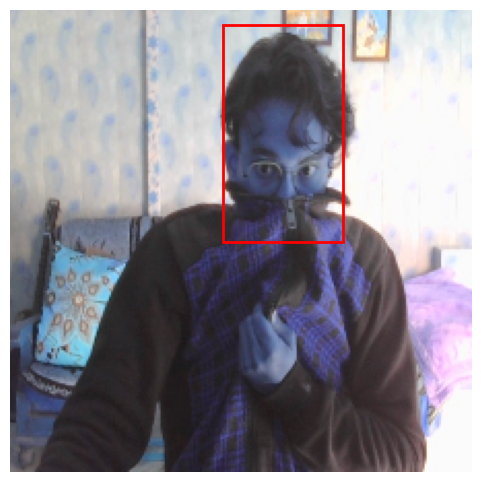

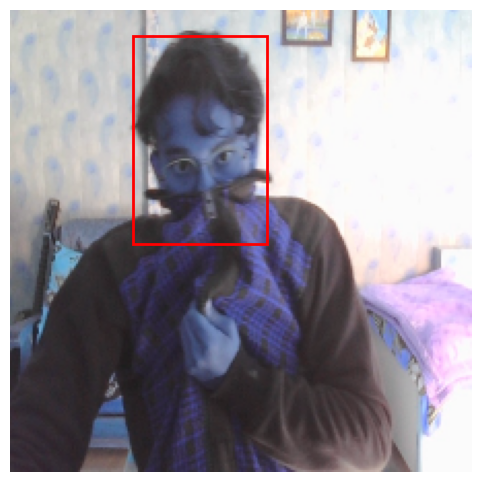

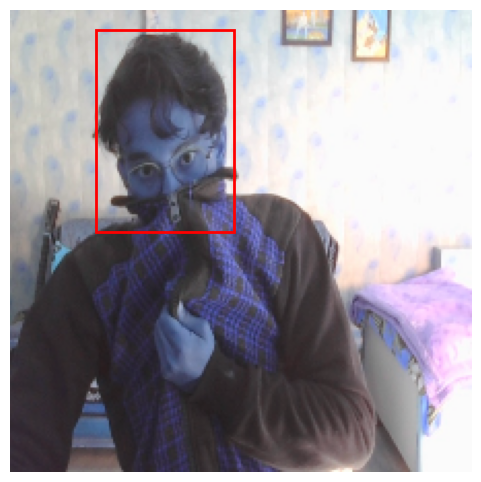

In [55]:
def plot_images_with_boxes(images, boxes, num_images=3, input_size=(224, 224)):
    for i in range(num_images):
        img = images[i]
        img = (img * 255).astype(np.uint8)  # Rescale to original pixel values
        plt.figure(figsize=(6, 6))
        plt.imshow(img)

        for box in boxes[i]:
            x_min = int(box[0] * input_size[0])
            y_min = int(box[1] * input_size[1])
            x_max = int(box[2] * input_size[0])
            y_max = int(box[3] * input_size[1])
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, edgecolor='red', facecolor='none', linewidth=2))

        plt.axis('off')
        plt.show()

# Plot a few images with their bounding boxes
plot_images_with_boxes(images, boxes)

In [8]:
# spliting the data

In [56]:
# Split data
train_images, val_images, train_boxes, val_boxes, train_labels, val_labels = train_test_split(
    images, boxes, labels, test_size=0.2, random_state=42
)

In [57]:
train_images.shape

(48, 224, 224, 3)

In [77]:
def iou_loss(y_true, y_pred):
    """
    Calculate Intersection over Union (IoU) loss.
    
    Args:
        y_true: Tensor of ground truth bounding boxes with shape (batch_size, 4)
                Format: [x_min, y_min, x_max, y_max].
        y_pred: Tensor of predicted bounding boxes with shape (batch_size, 4)
                Format: [x_min, y_min, x_max, y_max].
                
    Returns:
        IoU loss: 1 - mean IoU over the batch.
    """
    # Calculate intersection
    x_min_inter = tf.maximum(y_true[..., 0], y_pred[..., 0])
    y_min_inter = tf.maximum(y_true[..., 1], y_pred[..., 1])
    x_max_inter = tf.minimum(y_true[..., 2], y_pred[..., 2])
    y_max_inter = tf.minimum(y_true[..., 3], y_pred[..., 3])
    
    inter_area = tf.maximum(x_max_inter - x_min_inter, 0) * tf.maximum(y_max_inter - y_min_inter, 0)
    
    # Calculate areas of ground truth and predicted boxes
    true_area = (y_true[..., 2] - y_true[..., 0]) * (y_true[..., 3] - y_true[..., 1])
    pred_area = (y_pred[..., 2] - y_pred[..., 0]) * (y_pred[..., 3] - y_pred[..., 1])
    
    # Calculate union
    union_area = true_area + pred_area - inter_area
    
    # Calculate IoU
    iou = inter_area / tf.maximum(union_area, 1e-6)  # Avoid division by zero
    
    # IoU loss
    iou_loss = 1 - iou  # IoU loss is (1 - IoU)
    
    # Return mean IoU loss over the batch
    return tf.reduce_mean(iou_loss)

In [78]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.regularizers import l2


In [79]:
def create_model(input_shape=(224, 224, 3), num_classes=2):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    # Feature extraction
    x = base_model.output
    x = Flatten()(x)

    # Bounding box regression head
    bbox_head = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    bbox_head = Dense(4, activation='sigmoid', name='bbox_head')(bbox_head)

    # Classification head
    class_head = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    class_head = Dropout(0.3)(class_head)
    class_head = Dense(num_classes, activation='softmax', name='class_head')(class_head)

    # Define the model with multiple outputs
    model = Model(inputs=base_model.input, outputs=[bbox_head, class_head])

    # Compile the model
    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={
        'bbox_head': iou_loss,
        'class_head': 'sparse_categorical_crossentropy'
    },
    metrics={
        'bbox_head': 'mse',
        'class_head': 'accuracy'
    }
)
    
    return model

# custom data generator

In [80]:
class MultiOutputDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, boxes, labels, batch_size):
        """
        Custom Data Generator for multi-output models.
        Args:
            images: Array of image data.
            boxes: Array of bounding box data with shape (num_samples, 4).
            labels: Array of class labels with shape (num_samples,).
            batch_size: Number of samples per batch.
        """
        self.images = images
        self.boxes = np.array(boxes)  # Ensure boxes are a NumPy array
        self.labels = np.array(labels)  # Ensure labels are a NumPy array
        self.batch_size = batch_size
        self.indices = np.arange(len(images))

    def __len__(self):
        """
        Number of batches per epoch.
        """
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        """
        Generate one batch of data.
        Args:
            idx: Index of the batch.
        Returns:
            A batch of images and corresponding labels for bbox and class.
        """
        # Select indices for this batch
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = self.images[batch_indices]
        batch_boxes = self.boxes[batch_indices]
        batch_labels = self.labels[batch_indices]

        # Fix shapes to ensure compatibility with the model
        batch_boxes = np.squeeze(batch_boxes)  # Remove extra dimensions if necessary
        batch_labels = np.squeeze(batch_labels)  # Ensure labels are 1D

        # Return images and dictionary for multi-output model
        return np.array(batch_images), {
            'bbox_head': batch_boxes,
            'class_head': batch_labels,
        }

    def on_epoch_end(self):
        """
        Shuffle indices at the end of each epoch.
        """
        np.random.shuffle(self.indices)


In [81]:
# Create data generators
train_generator = MultiOutputDataGenerator(train_images, train_boxes, train_labels, batch_size=8)
val_generator = MultiOutputDataGenerator(val_images, val_boxes, val_labels, batch_size=8)

In [82]:
print("Generator Length:", len(train_generator))

Generator Length: 6


In [83]:
batch_images, batch_outputs = train_generator[0]
print("Batch Images Shape:", batch_images.shape)
print("Batch Outputs (BBox):", batch_outputs['bbox_head'].shape)
print("Batch Outputs (Class):", batch_outputs['class_head'].shape)

Batch Images Shape: (8, 224, 224, 3)
Batch Outputs (BBox): (8, 4)
Batch Outputs (Class): (8,)


In [84]:
for i in range(5):
    print(train_boxes[i])
    print(train_labels[i])

[[0.4365234375 0.16331845238095238 0.6695033482142857 0.6302083333333333]]
[0]
[[0.2746930803571429 0.04427083333333335 0.5648716517857143
  0.48139880952380953]]
[1]
[[0.6136997767857142 0.4144345238095238 0.9052734375 0.9259672619047618]]
[0]
[[0.25795200892857145 0.24516369047619052 0.041713169642857185
  0.6990327380952379]]
[1]
[[0.7629743303571428 0.18377976190476192 0.9973493303571429
  0.6488095238095237]]
[1]


In [85]:
model = create_model(input_shape=(224, 224, 3), num_classes=2)

In [87]:
print(train_images.dtype)  # Should be a numeric type like float32
print(train_boxes.dtype)   # Should be float32 for bounding boxes
print(train_labels.dtype)  # Should be int32 for class labels


float64
object
object


In [88]:
train_images = train_images.astype('float32')
train_boxes = train_boxes.astype('float32')
train_labels = train_labels.astype('int32')

val_images = val_images.astype('float32')
val_boxes = val_boxes.astype('float32')
val_labels = val_labels.astype('int32')


In [89]:
history = model.fit(
    MultiOutputDataGenerator(train_images, train_boxes, train_labels, batch_size=8),
    validation_data=MultiOutputDataGenerator(val_images, val_boxes, val_labels, batch_size=8),
    epochs=20
)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - bbox_head_loss: 0.9890 - bbox_head_mse: 0.1575 - class_head_accuracy: 0.7821 - class_head_loss: 0.6193 - loss: 11.4708 - val_bbox_head_loss: 1.0000 - val_bbox_head_mse: 0.1396 - val_class_head_accuracy: 1.0000 - val_class_head_loss: 4.3170e-05 - val_loss: 9.8837
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 553ms/step - bbox_head_loss: 1.0000 - bbox_head_mse: 0.1970 - class_head_accuracy: 1.0000 - class_head_loss: 2.7159e-04 - loss: 9.6062 - val_bbox_head_loss: 1.0000 - val_bbox_head_mse: 0.1493 - val_class_head_accuracy: 1.0000 - val_class_head_loss: 2.3842e-07 - val_loss: 8.7516
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 562ms/step - bbox_head_loss: 1.0000 - bbox_head_mse: 0.1941 - class_head_accuracy: 1.0000 - class_head_loss: 2.9442e-06 - loss: 8.5070 - val_bbox_head_loss: 1.0000 - val_bbox_head_mse: 0.1524 - val_class_head_accuracy: 1.0000 - val_class_head_loss: 7.4506e-08 - val_loss: 7.7589
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 559ms/step -

In [ ]:
evaluation_results = model.evaluate(val_generator)
print("Evaluation Results:", evaluation_results)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - bbox_head_loss: 0.1726 - bbox_head_mse: 0.1708 - class_head_accuracy: 1.0000 - class_head_loss: 0.0000e+00 - loss: 1.3012
Evaluation Results: [1.3028846979141235, 0.17512834072113037, 0.0, 0.17255540192127228, 1.0]


In [48]:
val_image = val_images[0]
val_image_batch = np.expand_dims(val_image, axis=0)
predicted_boxes, predicted_class = model.predict(val_image_batch)

# Extract and scale bounding boxes
predicted_boxes = predicted_boxes[0]  # Extract first prediction
predicted_boxes = np.clip(predicted_boxes, 0, 1)  # Clamp to [0, 1]

# Scale to image size (224x224)
x_min = predicted_boxes[0] 
y_min = predicted_boxes[1] 
x_max = predicted_boxes[2] 
y_max = predicted_boxes[3] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [49]:
def plot_predictions(image, box, predicted_class):
    img = (image * 255).astype(np.uint8)  # Convert to original pixel range
    plt.figure(figsize=(6, 6))
    plt.imshow(img)

    # Unpack and plot bounding box
    x_min, y_min, x_max, y_max = box
    plt.gca().add_patch(
        plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                      edgecolor="blue", facecolor="none", linewidth=2)
    )
    plt.title(f'Predicted Class: {"Mask" if predicted_class[0] > 0.5 else "No Mask"}')
    plt.axis("off")
    plt.show()

In [50]:
print(x_min,x_max,y_min,y_max)

1.0 1.0 5.409092e-20 1.0


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

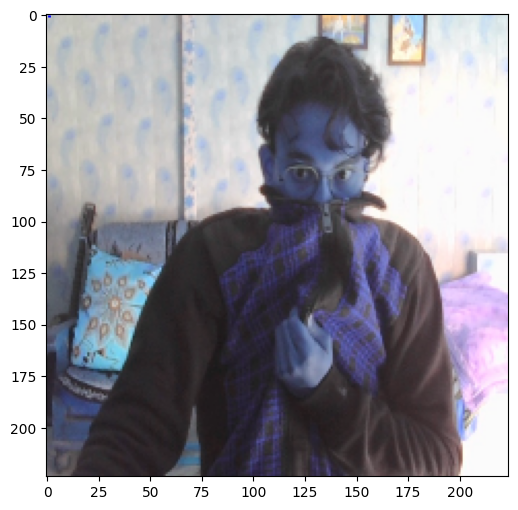

In [52]:
plot_predictions(val_image, (x_min, y_min, x_max, y_max), predicted_class)


In [64]:

def live_inference(model, input_size=(224, 224)):
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Get original frame dimensions
        original_height, original_width = frame.shape[:2]

        # Preprocess frame
        original_frame = frame.copy()
        frame = cv2.resize(frame, input_size)
        frame = frame / 255.0
        frame = np.expand_dims(frame, axis=0)

        # Model prediction
        bbox_pred, class_pred = model.predict(frame)

        # Rescale bounding box to original frame size
        x_min = int(bbox_pred[0][0] * original_width)
        y_min = int(bbox_pred[0][1] * original_height)
        x_max = int(bbox_pred[0][2] * original_width)
        y_max = int(bbox_pred[0][3] * original_height)

        # Draw bounding box and label
        label = class_pred
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        cv2.rectangle(original_frame, (x_min, y_min), (x_max, y_max), color, 2)
        cv2.putText(original_frame, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        # Display the frame
        cv2.imshow("Live Inference", original_frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Run live inference
live_inference(model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'putText'
> Overload resolution failed:
>  - Can't convert object to 'str' for 'text'
>  - Can't convert object to 'str' for 'text'
